In [184]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.labelpad'] = 8.0
plt.rcParams['figure.constrained_layout.h_pad'] = 0
plt.rcParams['text.usetex'] = True
plt.rc('text', usetex=True)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.tick_params(axis='both', which='minor', labelsize=18)
import matplotlib.ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.close()

plt.rc('font',family='Times New Roman')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
config = {
    "font.size": 15,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}

### 三角网格

In [185]:
# 网格划分数目，每一个正方形网格内有两个等腰直角三角形
Nx = Ny = 64

# 管理网格点的坐标
class Points:
    x_space = np.linspace(0, 1, Nx + 1, endpoint=True)
    y_space = np.linspace(0, 1, Ny + 1, endpoint=True)
    yy, xx = np.meshgrid(y_space, x_space)
    xy = np.stack([xx, yy], axis=2)

    # i[x序列,y序列]，返回第i个点的坐标
    @staticmethod
    def get(i):
        # i for [0 to Nx ,0 to Ny]
        return Points.xy[i[0], i[1]]

    # 返回第i个点的全局索引，按行排序
    @staticmethod
    def global_idx(i):
        return i[0] * (Nx + 1) + i[1]

In [186]:
class TriangleElement:

    def __init__(self, i, j, k):
        # i,j,k for [0,1] 三个点所处的行列序列
        self.i = i
        self.j = j
        self.k = k

    # 获得坐标

    @property
    def p1(self):
        return Points.get(self.i)
    @property
    def p2(self):
        return Points.get(self.j)
    @property
    def p3(self):
        return Points.get(self.k)

    @property
    def area(self):
        # 返回三角形面积
        return (self.p2[0] * self.p3[1] - self.p2[1] * self.p3[0] +
            self.p3[0] * self.p1[1] - self.p3[1] * self.p1[0] +
            self.p1[0] * self.p2[1] - self.p1[1] * self.p2[0]) / 2
    
    # 计算每一个三角元对于刚度矩阵的贡献
    def add_local_stiffness(self, global_stiffness: np.array):
        gi = Points.global_idx(self.i)
        gj = Points.global_idx(self.j)
        gk = Points.global_idx(self.k)
        sub_idx = [gi, gj, gk]
        i, j, k = Points.get(self.i), Points.get(self.j), Points.get(self.k)
        local_stiff = np.sum(np.array(
            [[(j - k) ** 2, (i - k) * (k - j), (i - j) * (j - k)],
             [(i - k) * (k - j), (i - k) ** 2, (k - i) * (i - j)],
             [(i - j) * (j - k), (k - i) * (i - j), (i - j) ** 2]]), axis=2) / self.area / 4
        global_stiffness[np.ix_(sub_idx, sub_idx)] += local_stiff
    
    # 计算每一个三角元对于载荷向量的贡献
    def add_local_load(self, q: callable, global_load: np.array):
        gi = Points.global_idx(self.i)
        gj = Points.global_idx(self.j)
        gk = Points.global_idx(self.k)
        i, j, k = Points.get(self.i), Points.get(self.j), Points.get(self.k)

        def compose_fun(local_idx):
            if local_idx == 0:
                li, lj, lk = i, j, k
            if local_idx == 1:
                lk, li, lj = i, j, k
            if local_idx == 2:
                lj, lk, li = i, j, k

            def _fun(x, y):
                _r = (x * lj[1] - lj[0] * y + lj[0] * lk[1] + lk[0] * y - x * lk[1] - lk[0] * lj[1]) / 2 / self.area
                return _r * q(x, y)

            return _fun

        global_load[gi] += self.quadrature(compose_fun(0))
        global_load[gj] += self.quadrature(compose_fun(1))
        global_load[gk] += self.quadrature(compose_fun(2))
    
    def quadrature(self, q: callable):
        return q((self.p1[0] + self.p2[0] + self.p3[0]) / 3, (self.p1[1] + self.p2[1] + self.p3[1]) / 3) * self.area

In [187]:
def q(xx, yy):
    m = np.sqrt(xx**2 + yy**2)
    m = np.where(m > 0.25, 0, 0.25 - m)
    return m

# 初始化结构网格
element_list = []
for ix in range(Nx):
    for iy in range(Ny):
        element_list.append(TriangleElement((ix, iy), (ix + 1, iy), (ix, iy + 1)))
        element_list.append(TriangleElement((ix, iy + 1), (ix + 1, iy), (ix + 1, iy + 1)))

# 获得刚度矩阵
global_stiffness = np.zeros(((Nx + 1) * (Ny + 1), (Nx + 1) * (Ny + 1)))
[te.add_local_stiffness(global_stiffness) for te in element_list]
# 索引网格非边界节点
interior_idx = (Nx + 1) * np.arange(1, Nx).reshape(Nx - 1, 1) + np.arange(1, Ny).reshape(1, Ny - 1)
interior_idx = interior_idx.ravel()
global_stiffness = global_stiffness[np.ix_(interior_idx, interior_idx)]

# 计算载荷
global_load = np.zeros((Nx + 1) * (Ny + 1))
[te.add_local_load(q, global_load) for te in element_list]
global_load = global_load[interior_idx]

res = np.linalg.solve(global_stiffness, global_load)
res = res.reshape(Nx - 1, Ny - 1)
res = np.pad(res, pad_width=1, mode='constant', constant_values=0)

#### 绘制结果

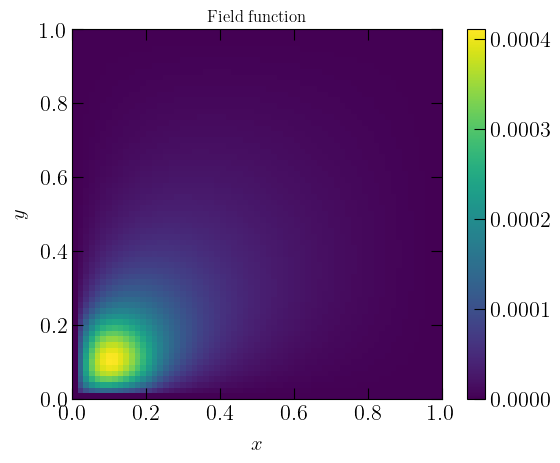

In [188]:
plt.imshow(res ,extent=[0, 1, 0, 1], origin='lower')
plt.colorbar()
plt.xlabel(r'$x$',fontsize = 15)
plt.ylabel(r'$y$',fontsize = 15)
plt.title('Field function')
plt.savefig('Fig1.pdf',bbox_inches='tight')

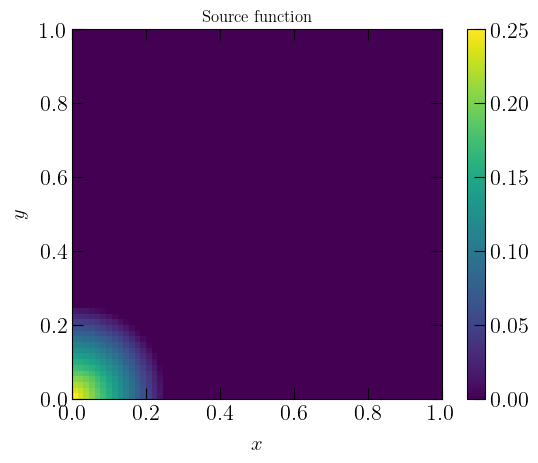

In [189]:
x_space = np.linspace(0, 1, Nx + 1, endpoint=True)
y_space = np.linspace(0, 1, Ny + 1, endpoint=True)
yy, xx = np.meshgrid(y_space, x_space)
m = q(xx, yy)

plt.imshow(m ,extent=[0, 1, 0, 1], origin='lower')
plt.colorbar()
plt.xlabel(r'$x$',fontsize = 15)
plt.ylabel(r'$y$',fontsize = 15)
plt.title('Source function')
plt.savefig('Fig2.pdf',bbox_inches='tight')

In [190]:
x_space = np.linspace(0, 1, Nx + 1)
y_space = np.linspace(0, 1, Ny + 1)
yy, xx = np.meshgrid(y_space, x_space)
xy = np.stack([xx, yy], axis=2)
